# Image segmentation

Extend your ResNet18 implementation to include a segmentation capabilities. The simplest extension of a backbone network is to simply generate the predictions at the last convolutional feature layer and then upsample them to fit the input image dimensions as described in https://arxiv.org/pdf/1411.4038.pdf (FCN-32s).

For this exercise you will be using the following dataset: https://www.kaggle.com/kumaresanmanickavelu/lyft-udacity-challenge - You don't have to download it from kaggle as it is already hosted on drive (the script to download it is a few cells down).

For this task, implement the FCN-32s (https://arxiv.org/pdf/1411.4038.pdf), however this is one of the first and simplest fully convolutional segmentation networks and the results will be coarse. You can optionally extend your network with more complex segmentation heads.

A few network architecture that you can optionally implement to improve the results:
- the full FCN network described in https://arxiv.org/pdf/1411.4038.pdf
- PSP-Net https://arxiv.org/pdf/1612.01105.pdf
- DeeplabV3 https://arxiv.org/pdf/1706.05587.pdf


Additionally, implement the U-Net architecture https://arxiv.org/pdf/1505.04597.pdf and use it as a segmentation network. Compare it to your FCN-32s implementation.



## Network implementation

In [ ]:
import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import torchvision
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
import random

In [ ]:
def bilinear_kernel(in_channels, out_channels, kernel_size):
    factor = (kernel_size + 1) // 2
    if kernel_size % 2 == 1:
      center = factor - 1
    else:
      center = factor - 0.5

    og = (torch.arange(kernel_size).reshape(-1, 1), torch.arange(kernel_size).reshape(1, -1))
    filt = (1 - torch.abs(og[0] - center) / factor) * (1 - torch.abs(og[1] - center) / factor)
    weight = torch.zeros((in_channels, out_channels, kernel_size, kernel_size))
    for i in range(out_channels):
        weight[i, i % in_channels, :, :] = filt

    return weight

In [ ]:
class ResidualBlock18(nn.Module):
  def __init__(self, in_channels, out_channels, stride):
    super(ResidualBlock18, self).__init__()

    self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
    self.batchnorm1 = nn.BatchNorm2d(out_channels)

    self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
    self.batchnorm2 = nn.BatchNorm2d(out_channels)

    self.identity_mapping = None
    if stride != 1 or in_channels != out_channels:
      self.identity_mapping = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
        nn.BatchNorm2d(out_channels)
      )

  def forward(self, x):
    identity = x

    c1 = self.conv1(x)
    bn1 = self.batchnorm1(c1)
    a1 = nn.functional.relu(bn1)

    c2 = self.conv2(a1)
    bn2 = self.batchnorm2(c2)

    if self.identity_mapping is not None:
      identity = self.identity_mapping(x)

    bn2 += identity
    out = nn.functional.relu(bn2)

    return out

In [ ]:
class ResNet18FCN(nn.Module):
  def __init__(self, img_channels, num_classes):
    super(ResNet18FCN, self).__init__()

    self.conv1 = nn.Conv2d(in_channels=img_channels, out_channels=64, kernel_size=7, stride=2, padding=3, bias=False)
    self.batchnorm1 = nn.BatchNorm2d(64)
    self.pool1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

    self.resblock1 = nn.Sequential(
      ResidualBlock18(in_channels=64, out_channels=64, stride=1),
      ResidualBlock18(in_channels=64, out_channels=64, stride=1)
    )
    self.resblock2 = nn.Sequential(
      ResidualBlock18(in_channels=64, out_channels=128, stride=2),
      ResidualBlock18(in_channels=128, out_channels=128, stride=1)
    )
    self.resblock3 = nn.Sequential(
      ResidualBlock18(in_channels=128, out_channels=256, stride=2),
      ResidualBlock18(in_channels=256, out_channels=256, stride=1)
    )
    self.resblock4 = nn.Sequential(
      ResidualBlock18(in_channels=256, out_channels=512, stride=2),
      ResidualBlock18(in_channels=512, out_channels=512, stride=1)
    )

    self.conv2 = nn.Conv2d(512, num_classes, kernel_size=1, bias=False)
    self.batchnorm2 = nn.BatchNorm2d(num_classes)

    self.transposeconv = nn.ConvTranspose2d(num_classes, num_classes, kernel_size=64, padding=16, stride=32)
    self.transposeconv.weight.data.copy_(bilinear_kernel(num_classes, num_classes, 64))

    for module in self.modules():
      if isinstance(module, nn.Conv2d):
        nn.init.kaiming_normal_(module.weight, mode="fan_out", nonlinearity="relu")
      elif isinstance(module, nn.BatchNorm2d):
        nn.init.ones_(module.weight)
        nn.init.zeros_(module.bias)


  def forward(self, x):
    c1 = self.conv1(x)
    bn1 = self.batchnorm1(c1)
    a1 = nn.functional.relu(bn1)
    p1 = self.pool1(a1)

    rb1 = self.resblock1(p1)
    rb2 = self.resblock2(rb1)
    rb3 = self.resblock3(rb2)
    rb4 = self.resblock4(rb3)

    c2 = self.conv2(rb4)
    bn2 = self.batchnorm2(c2)
    out = self.transposeconv(bn2)

    return out

In [ ]:
class UNetBlock(nn.Module):
  def __init__(self, in_channels, out_channels):
    super(UNetBlock, self).__init__()

    self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False)
    self.batchnorm1 = nn.BatchNorm2d(out_channels)

    self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False)
    self.batchnorm2 = nn.BatchNorm2d(out_channels)


  def forward(self, x):
    c1 = self.conv1(x)
    bn1 = self.batchnorm1(c1)
    a1 = nn.functional.relu(bn1)

    c2 = self.conv2(a1)
    bn2 = self.batchnorm2(c2)
    out = nn.functional.relu(bn2)

    return out

In [ ]:
class UNetEncoderBlock(nn.Module):
  def __init__(self, in_channels, out_channels):
    super(UNetEncoderBlock, self).__init__()
    self.resblock = UNetBlock(in_channels, out_channels)
    self.pool = nn.MaxPool2d(kernel_size=2, stride=2)


  def forward(self, x):
    rb = self.resblock(x)
    out = self.pool(rb)

    return rb, out

In [ ]:
class UNetDecoderBlock(nn.Module):
  def __init__(self, in_channels, out_channels):
    super(UNetDecoderBlock, self).__init__()
    self.transposeconv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
    self.transposeconv.weight.data.copy_(bilinear_kernel(in_channels, out_channels, kernel_size=2))
    self.resblock = UNetBlock(2*out_channels, out_channels)


  def forward(self, x, residual):
    tc = self.transposeconv(x)
    out = self.resblock(torch.cat([tc, residual], axis=1))

    return out

In [ ]:
class UNet(nn.Module):
    def __init__(self, img_channels, num_classes):
      super(UNet, self).__init__()
      self.encoder1 = UNetEncoderBlock(in_channels=img_channels, out_channels=64)
      self.encoder2 = UNetEncoderBlock(in_channels=64, out_channels=128)
      self.encoder3 = UNetEncoderBlock(in_channels=128, out_channels=256)
      self.encoder4 = UNetEncoderBlock(in_channels=256, out_channels=512)

      self.bottleneck = UNetBlock(in_channels=512, out_channels=1024)

      self.decoder1 = UNetDecoderBlock(in_channels=1024, out_channels=512)
      self.decoder2 = UNetDecoderBlock(in_channels=512, out_channels=256)
      self.decoder3 = UNetDecoderBlock(in_channels=256, out_channels=128)
      self.decoder4 = UNetDecoderBlock(in_channels=128, out_channels=64)

      self.conv = nn.Conv2d(64, num_classes, kernel_size=1, bias=False)
      self.batchnorm = nn.BatchNorm2d(num_classes)

      for module in self.modules():
        if isinstance(module, nn.Conv2d):
          nn.init.kaiming_normal_(module.weight, mode="fan_out", nonlinearity="relu")
        elif isinstance(module, nn.BatchNorm2d):
          nn.init.ones_(module.weight)
          nn.init.zeros_(module.bias)


    def forward(self, x):
      e1_residual, e1 = self.encoder1(x)
      e2_residual, e2 = self.encoder2(e1)
      e3_residual, e3 = self.encoder3(e2)
      e4_residual, e4 = self.encoder4(e3)

      b = self.bottleneck(e4)

      d1 = self.decoder1(b, e4_residual)
      d2 = self.decoder2(d1, e3_residual)
      d3 = self.decoder3(d2, e2_residual)
      d4 = self.decoder4(d3, e1_residual)

      conv = self.conv(d4)
      out = self.batchnorm(conv)

      return out

## Download the dataset
Download a part of the Lyft self driving dataset split into training and validation sets - https://www.kaggle.com/kumaresanmanickavelu/lyft-udacity-challenge


The dataset contains 13 classes:
0 - unlabeled,
1 - building,
2 - fence,
3 - other
4 - pedestrian,
5 - pole
6 - road line
7 - road
8 - sidewalk
9 - vegetation
10 - car
11 - wall
12 - traffic sign






In [ ]:
!pip install --upgrade --no-cache-dir gdown
!gdown --id 1Mgxe0Nl19hxMhQqVvEpaRDNd_L_RaLNM
# if this link does not work try the other link
#!gdown --id 1wUFws0e5ArlYUg7NZiAjjrYOmTGCX_Fv
!rm -r data
!mkdir data
!unzip -q seg_data.zip -d ./data/

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1Mgxe0Nl19hxMhQqVvEpaRDNd_L_RaLNM
From (redirected): https://drive.google.com/uc?id=1Mgxe0Nl19hxMhQqVvEpaRDNd_L_RaLNM&confirm=t&uuid=5f5e847f-a6c0-4a90-a5aa-f90568ff712a
To: /content/seg_data.zip
100% 2.74G/2.74G [00:55<00:00, 49.5MB/s]


## Data loader

In [ ]:
class SegmentationDataset(Dataset):
  def __init__(self, train=True):
    dataset_path = "./data/seg_data/" + ("train" if train else "test")
    self.images = sorted(glob.glob(dataset_path+"/*/*/CameraRGB/*.png"))
    self.masks = sorted(glob.glob(dataset_path+"/*/*/CameraSeg/*.png"))
    self.resize_shape = (320, 416)

  def __len__(self):
    return len(self.images)

  def transform_image(self, image_path, mask_path):
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    mask = cv2.imread(mask_path, cv2.IMREAD_COLOR)[:,:,2]

    channels=3
    image = cv2.resize(image, dsize=(self.resize_shape[1], self.resize_shape[0]))
    mask = cv2.resize(mask, dsize=(self.resize_shape[1], self.resize_shape[0]))
    image = np.array(image).reshape((image.shape[0], image.shape[1], channels)).astype(np.float32) / 255.0
    mask = np.array(mask).reshape((image.shape[0], image.shape[1], 1))

    image = np.transpose(image, (2, 0, 1))
    mask = np.transpose(mask, (2, 0, 1))
    return image, mask

  def __getitem__(self, idx):
    image, mask = self.transform_image(self.images[idx], self.masks[idx])
    sample = {'image': image, "mask": mask, 'idx': idx}

    return sample

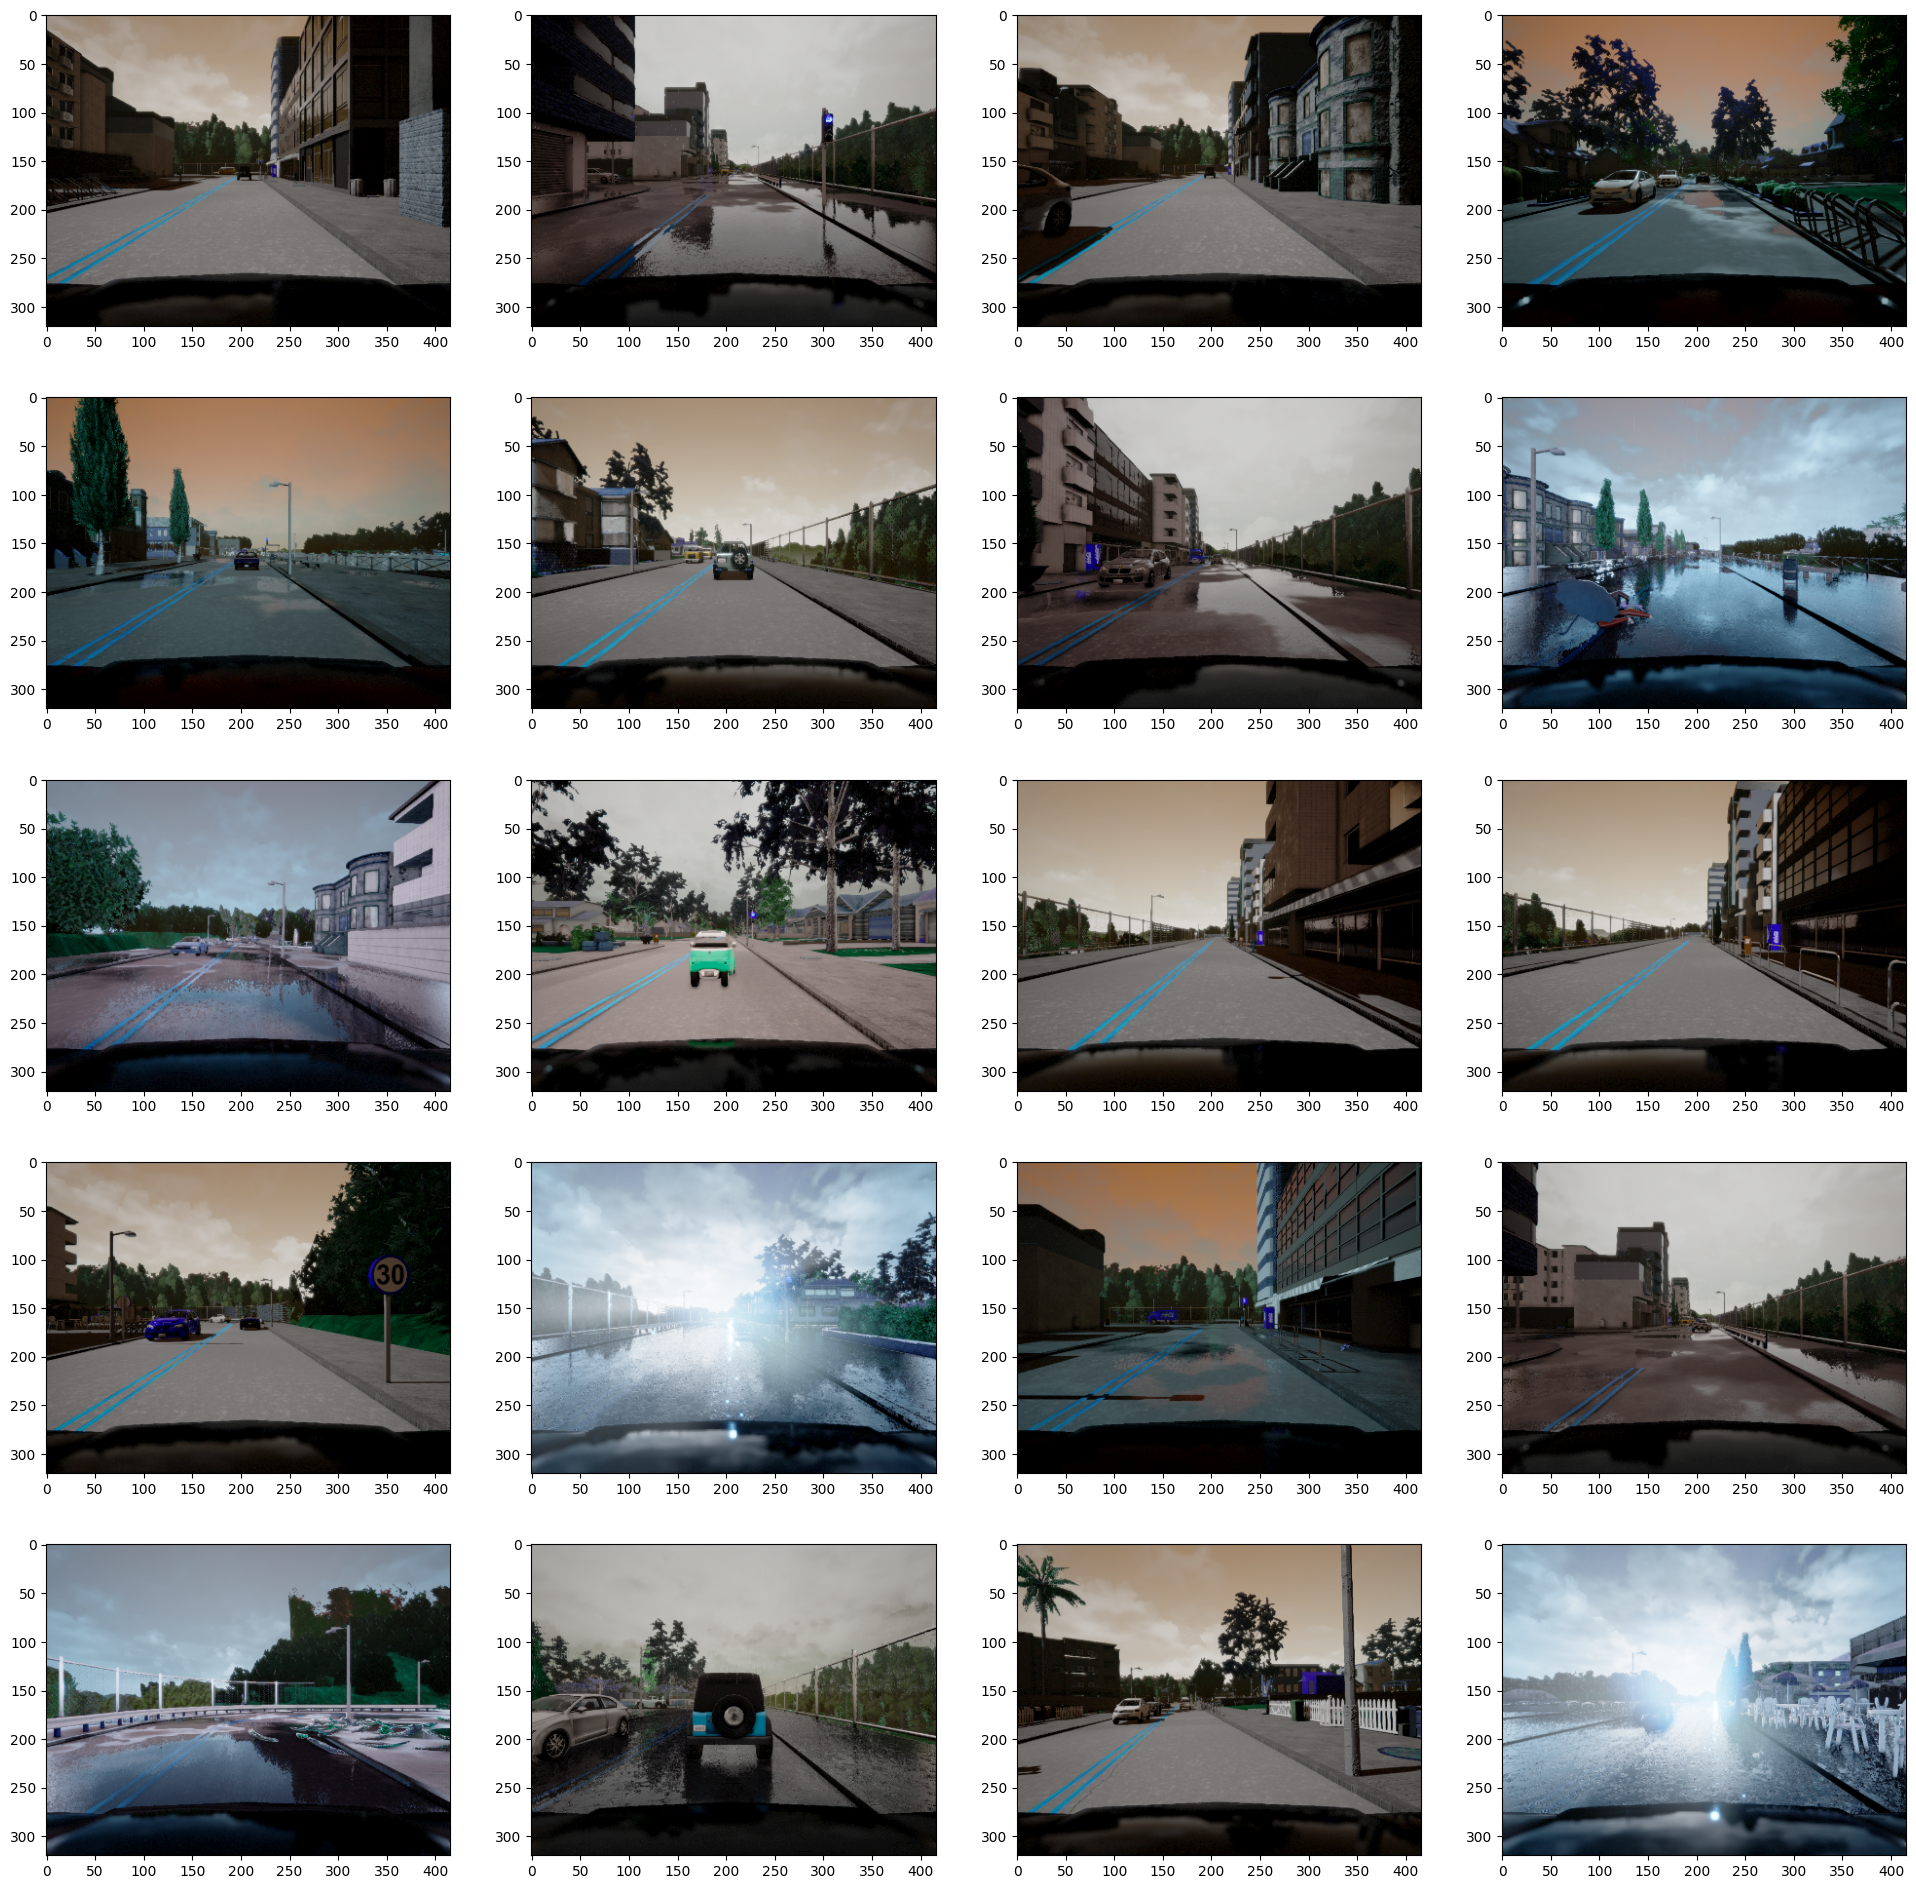

In [ ]:
trainset = SegmentationDataset(train=True)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = SegmentationDataset(train=False)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)


fig=plt.figure(figsize=(24, 24))
columns = 4
rows = 5
for i in range(rows*columns):
  data = trainset[np.random.randint(len(trainset))]
  input = data["image"]
  label = data["mask"]
  img = input.transpose((1,2,0))
  ax = fig.add_subplot(rows, columns, i+1)
  plt.imshow(img)
plt.show()



In [ ]:

net = ResNet18FCN(img_channels=3, num_classes=13)
net.cuda()

# Define the loss function
criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9, weight_decay=1e-5)

epochs=20
val_loss_min_fcn = np.Inf
train_loss_fcn = []
train_iou_fcn = []
resnet_fcn = None

for epoch in range(epochs):
  train_loss = 0.0
  total = 0
  total_step = len(trainloader)
  iou_scores = []
  with tqdm(total=len(trainset), desc ='Epoch: '+str(epoch+1)+"/"+str(epochs), unit='img') as prog_bar:
    for i, data in enumerate(trainloader, 0):
      inputs = data["image"]
      labels = data["mask"]
      inputs = inputs.cuda()
      labels = labels.cuda()

      optimizer.zero_grad()

      outputs = net(inputs)
      loss = criterion(outputs, labels[:,0,:,:].long())
      train_loss += loss.item()

      loss.backward()
      optimizer.step()

      outputs = torch.softmax(outputs, dim=1)
      _, preds = torch.max(outputs.data, 1)

      total += labels.size(0)
      prog_bar.set_postfix(**{'loss': loss.data.cpu().detach().numpy()})
      prog_bar.update(labels.size(0))

      predictions = preds.detach().cpu().numpy()
      labels = labels.detach().cpu().numpy()

      for j in range(len(predictions)):
        intersection = np.logical_and(predictions[j], labels[j])
        union = np.logical_or(predictions[j], labels[j])
        iou_scores.append(np.sum(intersection) / np.sum(union))

  epoch_loss = train_loss / total_step
  train_loss_fcn.append(epoch_loss)
  mean_iou = np.mean(iou_scores)
  train_iou_fcn.append(mean_iou)
  print(f'\ntraining loss: {epoch_loss:.4f}, training IOU: {mean_iou * 100:.2f} %')

  improvement = epoch_loss < val_loss_min_fcn
  if improvement:
    val_loss_min_fcn = epoch_loss
    resnet_fcn = net
    print("IMPROVEMENT")

Epoch: 1/20:   0%|          | 0/4000 [00:00<?, ?img/s]

KeyboardInterrupt: 

In [ ]:
net = UNet(img_channels=3, num_classes=13)
net.cuda()

# Define the loss function
criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9, weight_decay=1e-5)

epochs=20
val_loss_min_unet = np.Inf
train_loss_unet = []
train_iou_unet = []
unet = None

for epoch in range(epochs):
  train_loss = 0.0
  total = 0
  total_step = len(trainloader)
  iou_scores = []
  with tqdm(total=len(trainset), desc ='Epoch: '+str(epoch+1)+"/"+str(epochs), unit='img') as prog_bar:
    for i, data in enumerate(trainloader, 0):
      inputs = data["image"]
      labels = data["mask"]
      inputs = inputs.cuda()
      labels = labels.cuda()

      optimizer.zero_grad()

      outputs = net(inputs)
      loss = criterion(outputs, labels[:,0,:,:].long())
      train_loss += loss.item()

      loss.backward()
      optimizer.step()

      outputs = torch.softmax(outputs, dim=1)
      _, preds = torch.max(outputs.data, 1)

      total += labels.size(0)
      prog_bar.set_postfix(**{'loss': loss.data.cpu().detach().numpy()})
      prog_bar.update(labels.size(0))

      predictions = preds.detach().cpu().numpy()
      labels = labels.detach().cpu().numpy()

      for j in range(len(predictions)):
        intersection = np.logical_and(predictions[j], labels[j])
        union = np.logical_or(predictions[j], labels[j])
        iou_scores.append(np.sum(intersection) / np.sum(union))

  epoch_loss = train_loss / total_step
  train_loss_unet.append(epoch_loss)
  mean_iou = np.mean(iou_scores)
  train_iou_unet.append(mean_iou)
  print(f'\ntraining loss: {epoch_loss:.4f}, training IOU: {mean_iou * 100:.2f} %')

  improvement = epoch_loss < val_loss_min_unet
  if improvement:
    val_loss_min_unet = epoch_loss
    unet = net
    print("IMPROVEMENT")

Epoch: 1/20:   0%|          | 0/4000 [00:00<?, ?img/s]


training loss: 0.4551, training IOU: 96.09 %
IMPROVEMENT


Epoch: 2/20:   0%|          | 0/4000 [00:00<?, ?img/s]


training loss: 0.2370, training IOU: 98.15 %
IMPROVEMENT


Epoch: 3/20:   0%|          | 0/4000 [00:00<?, ?img/s]


training loss: 0.1836, training IOU: 98.68 %
IMPROVEMENT


Epoch: 4/20:   0%|          | 0/4000 [00:00<?, ?img/s]


training loss: 0.1631, training IOU: 98.80 %
IMPROVEMENT


Epoch: 5/20:   0%|          | 0/4000 [00:00<?, ?img/s]


training loss: 0.1420, training IOU: 99.00 %
IMPROVEMENT


Epoch: 6/20:   0%|          | 0/4000 [00:00<?, ?img/s]


training loss: 0.1292, training IOU: 99.11 %
IMPROVEMENT


Epoch: 7/20:   0%|          | 0/4000 [00:00<?, ?img/s]


training loss: 0.1219, training IOU: 99.17 %
IMPROVEMENT


Epoch: 8/20:   0%|          | 0/4000 [00:00<?, ?img/s]


training loss: 0.1139, training IOU: 99.23 %
IMPROVEMENT


Epoch: 9/20:   0%|          | 0/4000 [00:00<?, ?img/s]


training loss: 0.1085, training IOU: 99.27 %
IMPROVEMENT


Epoch: 10/20:   0%|          | 0/4000 [00:00<?, ?img/s]


training loss: 0.1051, training IOU: 99.31 %
IMPROVEMENT


Epoch: 11/20:   0%|          | 0/4000 [00:00<?, ?img/s]


training loss: 0.1010, training IOU: 99.34 %
IMPROVEMENT


Epoch: 12/20:   0%|          | 0/4000 [00:00<?, ?img/s]


training loss: 0.0979, training IOU: 99.36 %
IMPROVEMENT


Epoch: 13/20:   0%|          | 0/4000 [00:00<?, ?img/s]


training loss: 0.0953, training IOU: 99.38 %
IMPROVEMENT


Epoch: 14/20:   0%|          | 0/4000 [00:00<?, ?img/s]


training loss: 0.1033, training IOU: 99.27 %


Epoch: 15/20:   0%|          | 0/4000 [00:00<?, ?img/s]


training loss: 0.1627, training IOU: 98.82 %


Epoch: 16/20:   0%|          | 0/4000 [00:00<?, ?img/s]


training loss: 0.1001, training IOU: 99.35 %


Epoch: 17/20:   0%|          | 0/4000 [00:00<?, ?img/s]


training loss: 0.0930, training IOU: 99.39 %
IMPROVEMENT


Epoch: 18/20:   0%|          | 0/4000 [00:00<?, ?img/s]


training loss: 0.0892, training IOU: 99.42 %
IMPROVEMENT


Epoch: 19/20:   0%|          | 0/4000 [00:00<?, ?img/s]


training loss: 0.0867, training IOU: 99.44 %
IMPROVEMENT


Epoch: 20/20:   0%|          | 0/4000 [00:00<?, ?img/s]


training loss: 0.0847, training IOU: 99.45 %
IMPROVEMENT


## Evaluate on the test set:

Implement the evaluation on the test set. Use the mean IOU metric to evaluate the result. - https://stackoverflow.com/questions/31653576/how-to-calculate-the-mean-iu-score-in-image-segmentation



In [ ]:
nets = [unet, resnet_fcn]
for i in range(len(nets)):
  net = nets[i]
  net.eval()
  iou_scores = []

  with torch.no_grad():
    for j, data in enumerate(trainloader, 0):
      inputs = data["image"]
      labels = data["mask"]
      inputs = inputs.cuda()
      labels = labels.cuda()

      outputs = net(inputs)
      outputs = torch.softmax(outputs, dim=1)
      _, predicted = torch.max(outputs.data, 1)

      predictions = predicted.detach().cpu().numpy()
      labels = labels.detach().cpu().numpy()

      for k in range(len(predictions)):
        intersection = np.logical_and(predictions[k], labels[k])
        union = np.logical_or(predictions[k], labels[k])
        iou_scores.append(np.sum(intersection) / np.sum(union))

  mean_iou = np.mean(iou_scores)
  if i == 0:
    print(f"The Mean IOU of Unet is: {mean_iou* 100:.2f} %.")
  else:
    print(f"The Mean IOU of ResNet18FCN is: {mean_iou* 100:.2f} %.")

The Mean IOU of Unet is: 99.47 %.
The Mean IOU of ResNet18FCN is: 96.99 %.


## Visualize the results

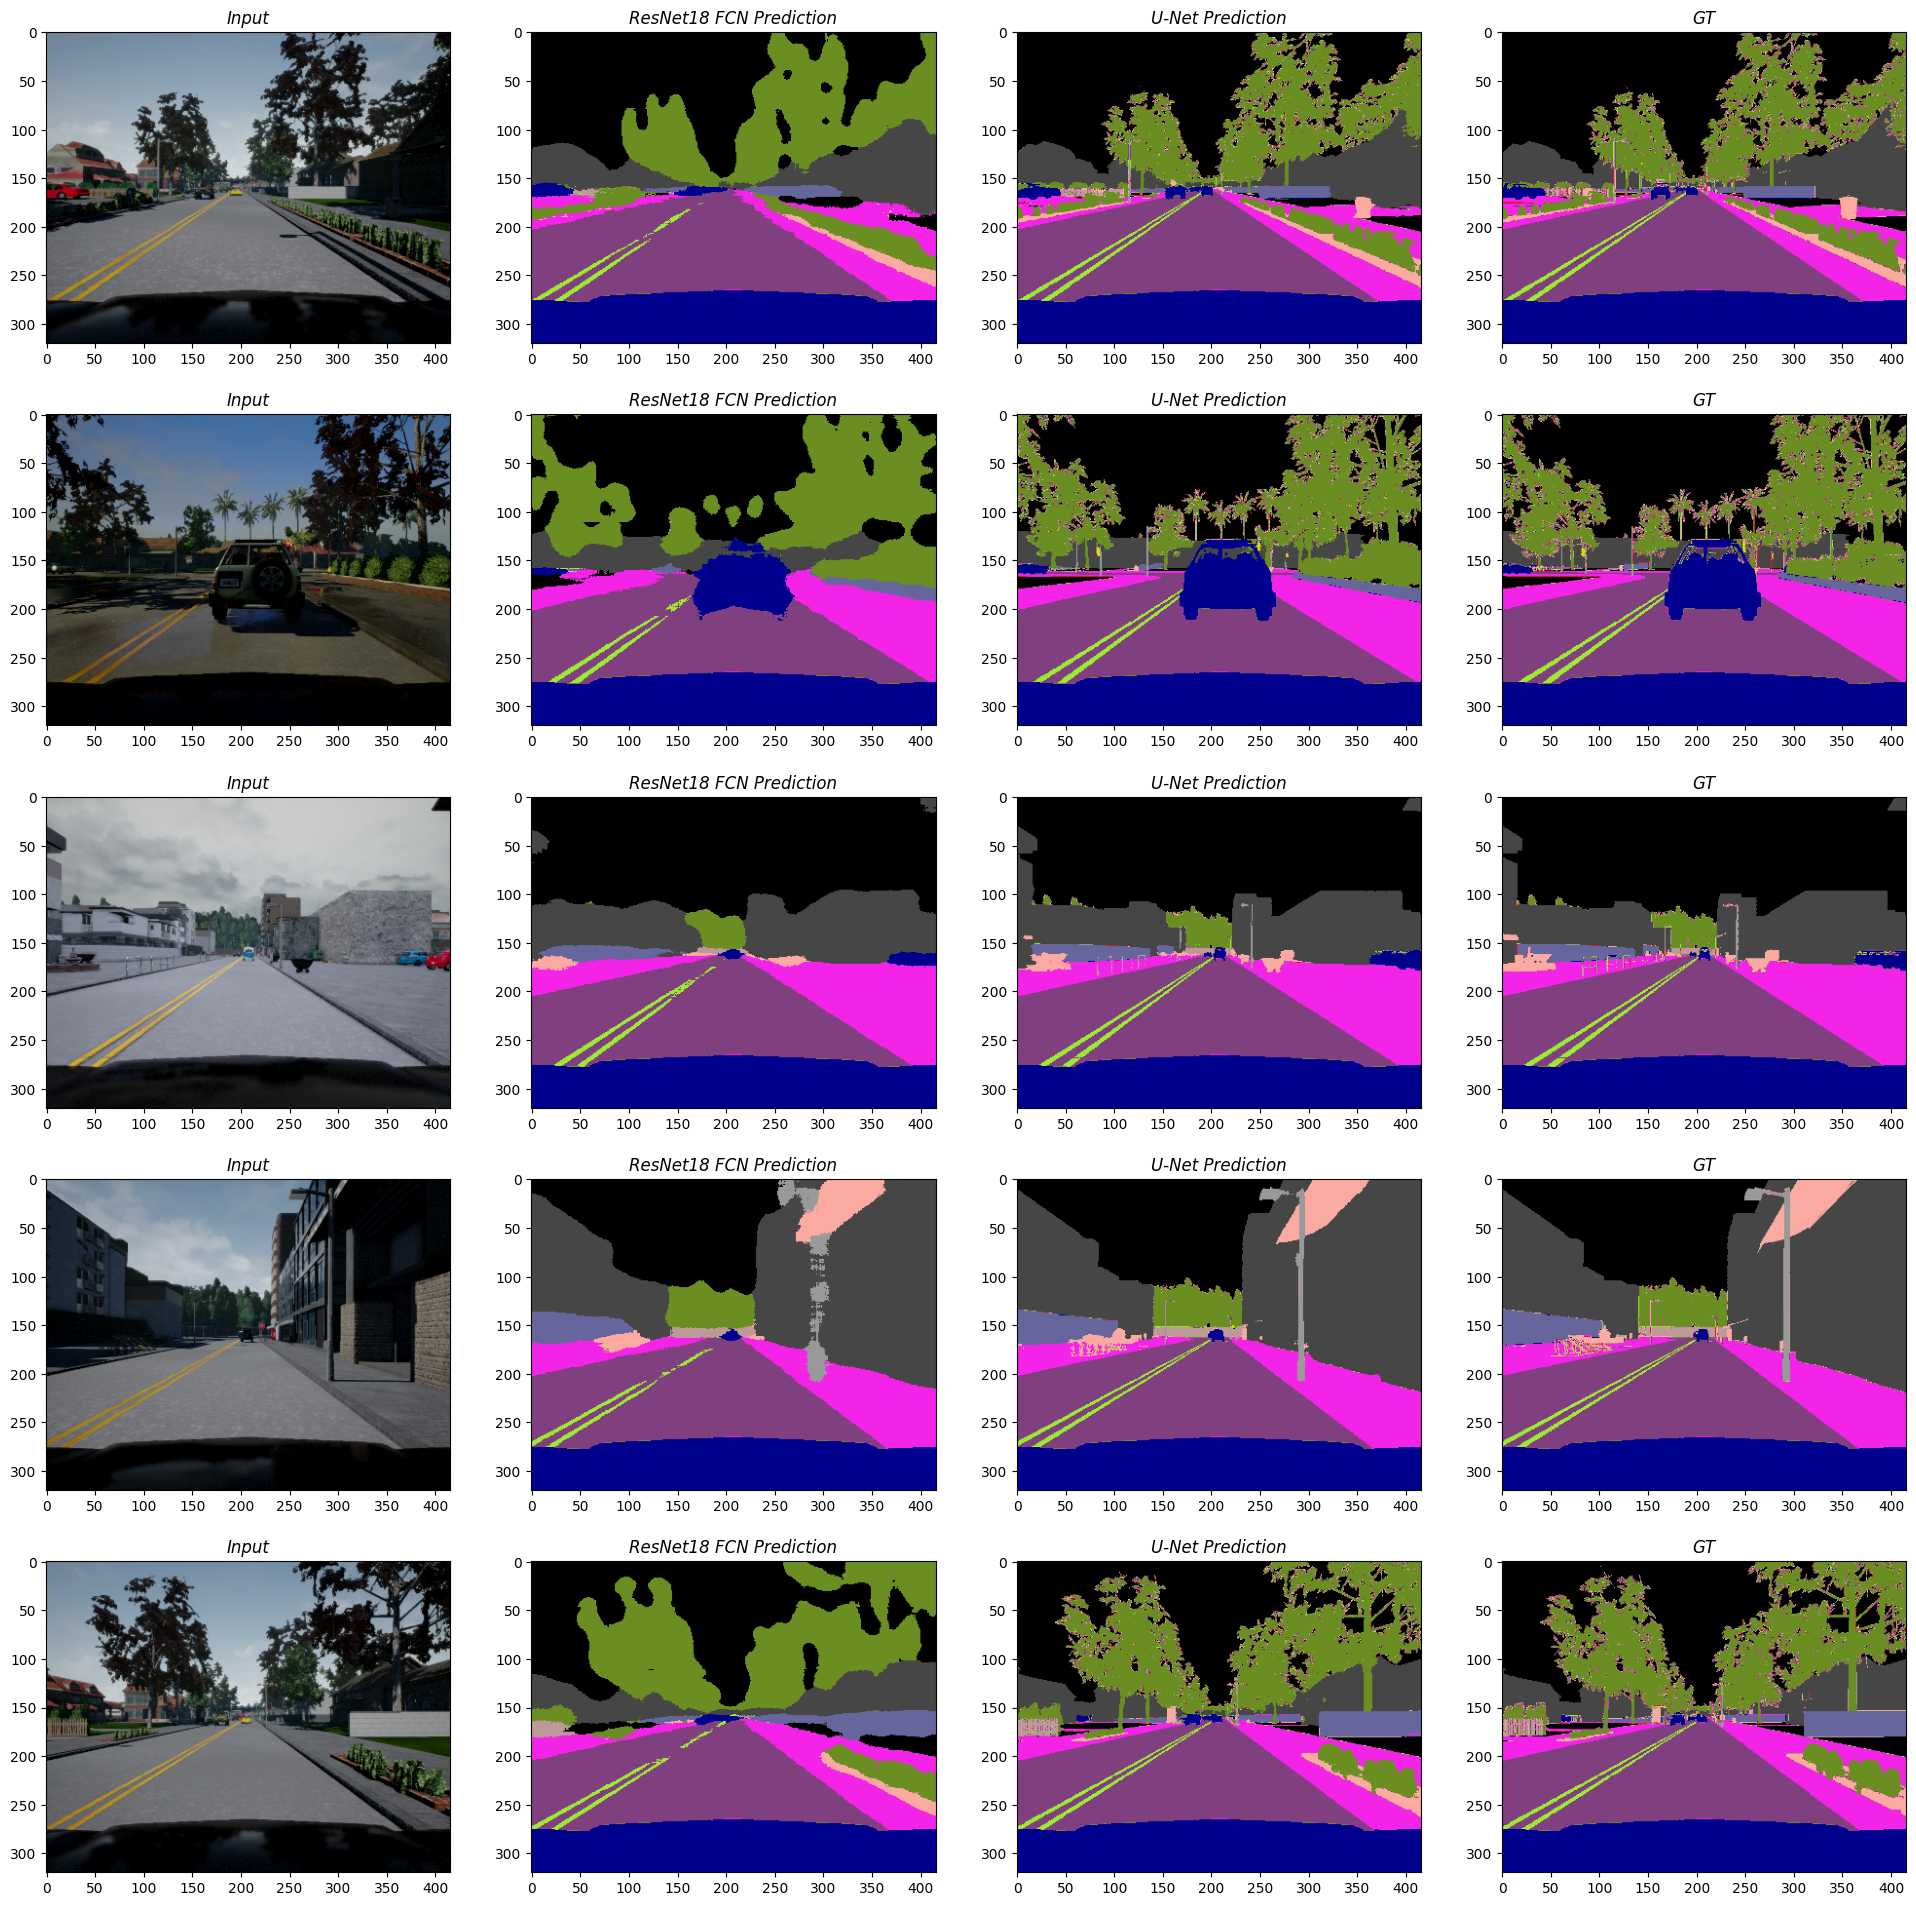

In [ ]:
import matplotlib.pyplot as plt

label_colors = np.array([
  [0,0,0], # unlabeled
  [70,70,70], # building
  [190,153,153], # fence
  [250,170,160], # other
  [220,20,60], # pedestrian
  [153,153,153], # pole
  [157,234,50], # road line
  [128,64,128], # road
  [244,35,232], # sidewalk
  [107,142,35], # vegetation
  [0,0,142], # car
  [102,102,156], # wall
  [220,220,0], # traffic sign
])


unet.eval()
resnet_fcn.eval()


fig=plt.figure(figsize=(24, 24))
columns = 4
rows = 5

for i in range(rows):
  batch = testset[np.random.randint(len(testset))]
  img = batch['image']
  labels = batch['mask']
  img_tensor = torch.from_numpy(img).cuda().unsqueeze(0)

  outputs_unet = unet(img_tensor)
  outputs_unet = torch.softmax(outputs_unet, dim=1)
  seg_mask_unet = np.argmax(outputs_unet[0,:,:,:].detach().cpu().numpy(), axis=0)
  seg_mask_unet_color = label_colors[seg_mask_unet]

  outputs_resnet_fcn = resnet_fcn(img_tensor)
  outputs_resnet_fcn = torch.softmax(outputs_resnet_fcn, dim=1)
  seg_mask_resnet_fcn = np.argmax(outputs_resnet_fcn[0,:,:,:].detach().cpu().numpy(), axis=0)
  seg_mask_resnet_fcn_color = label_colors[seg_mask_resnet_fcn]

  gt_mask_color = label_colors[labels[0,:,:]]

  img=img.transpose((1,2,0))
  img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
  labels = labels[0,:,:]

  ax = fig.add_subplot(rows, columns, i*columns+1)
  ax.set_title("Input", fontstyle='italic')
  plt.imshow(img)

  ax = fig.add_subplot(rows, columns, i*columns+2)
  ax.set_title("ResNet18 FCN Prediction", fontstyle='italic')
  plt.imshow(seg_mask_resnet_fcn_color)

  ax = fig.add_subplot(rows, columns, i*columns+3)
  ax.set_title("U-Net Prediction", fontstyle='italic')
  plt.imshow(seg_mask_unet_color)

  ax = fig.add_subplot(rows, columns, i*columns+4)
  ax.set_title("GT", fontstyle='italic')
  plt.imshow(gt_mask_color)


plt.show()

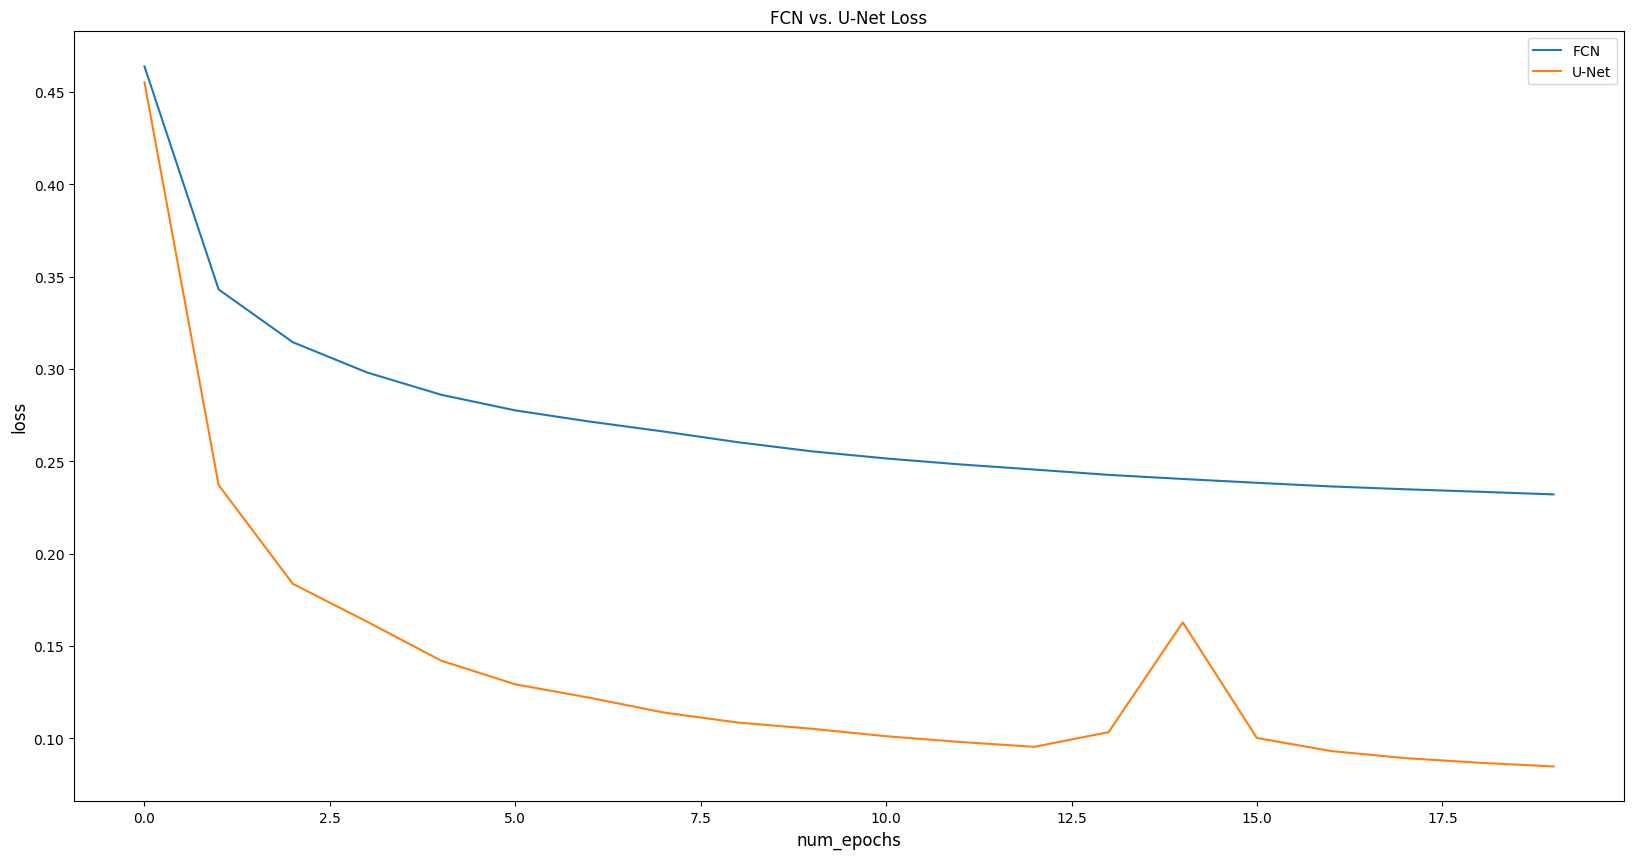

In [ ]:
fig = plt.figure(figsize=(20,10))
plt.title("FCN vs. U-Net Loss")
plt.plot(train_loss_fcn, label='FCN')
plt.plot(train_loss_unet, label='U-Net')
plt.xlabel('num_epochs', fontsize=12)
plt.ylabel('loss', fontsize=12)
plt.legend(loc='best')

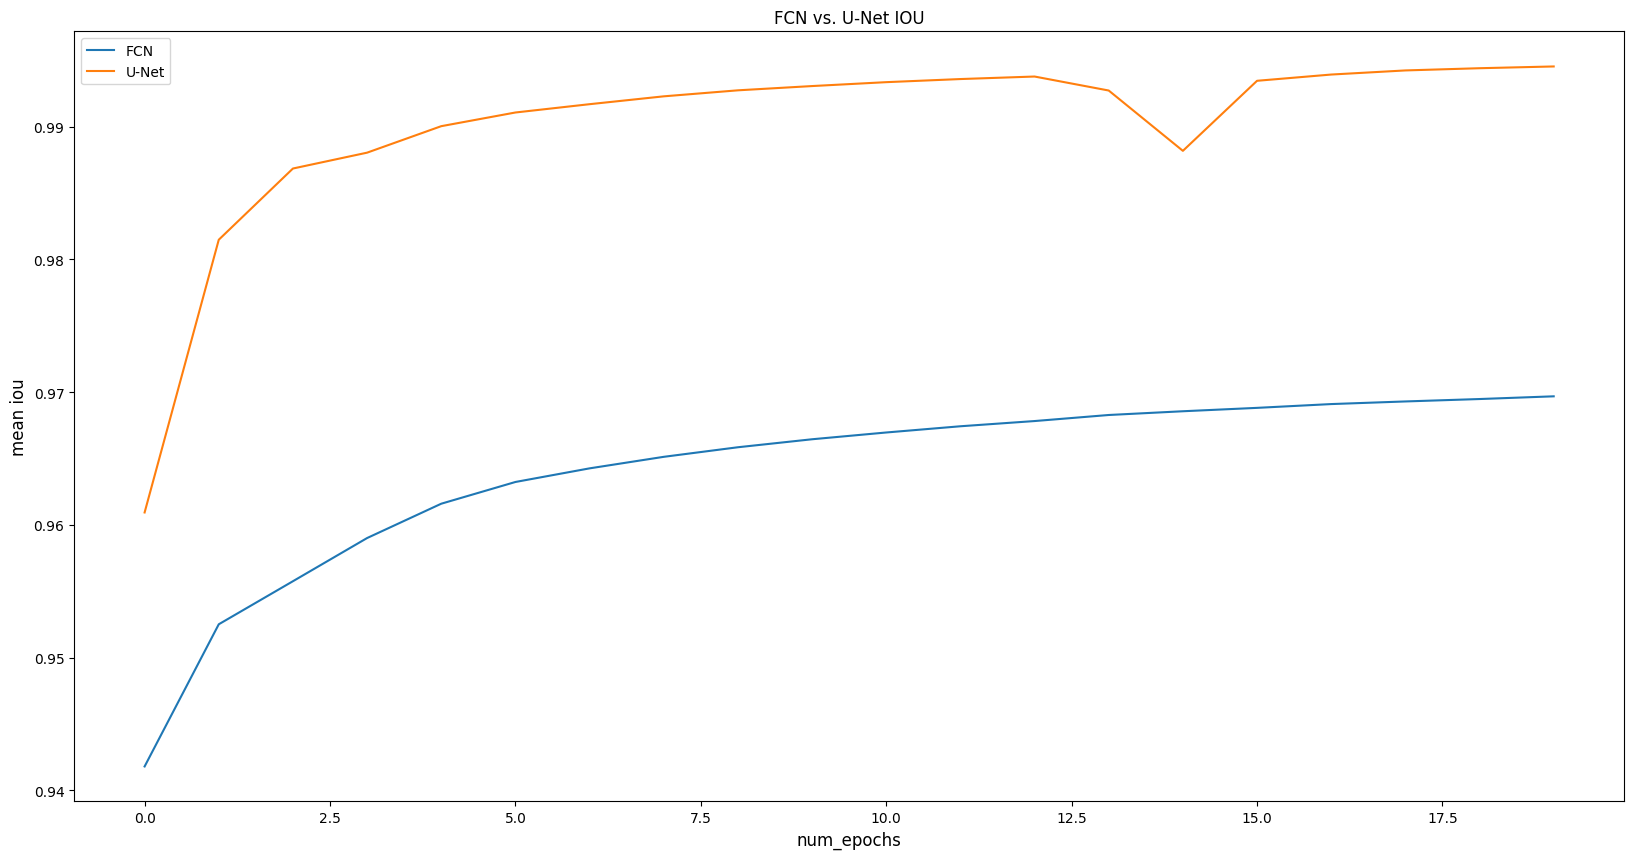

In [ ]:
fig = plt.figure(figsize=(20,10))
plt.title("FCN vs. U-Net IOU")
plt.plot(train_iou_fcn, label='FCN')
plt.plot(train_iou_unet, label='U-Net')
plt.xlabel('num_epochs', fontsize=12)
plt.ylabel('mean iou', fontsize=12)
plt.legend(loc='best')